# Modelo de **Hodgkin & Huxley**

Referencias:

1. https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model
2. Eugene M. Izhikevich, Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting, Computational Neuroscience, The MIT Press (2006)
3. https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/How_to_upload_an_image_to_Colab_.ipynb#scrollTo=KKTpNAGCWLeB

## **Ejercicio 1)** Importando librerías

**a)** Importe las librerías `numpy` para operar con arrays, `scipy` para utilizar rutinas de algebra lineal y `matplotlib.pyplot` para graficar.

**b)** Suba el archivo "libreria" `ode.py` que fabricó en el práctico 4), e impórtelo.

In [1]:
# 1.a)
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
# 1.b)
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
#import ode

def euler(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Euler.

    Argumentos de entrada:

        f : R^n,R -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Euler.

    # Ejemplos:
    """
    return x+h*f(x,t,p)

def rk4(f,x,t,h,p):
    """
    Calcula un paso de integración del método de Runge Kutta orden 4.

    Argumentos de entrada:

        f : R^n -> R^n
        x = x(t) : R^n
        t = tiempo : R
        h = paso de tiempo : R
        p = parametros : R^q

    Retorna aproximacion numérica de

        x(t+h) : R^n

    según el método de Runge-Kutta de orden 4.

    # Ejemplos:
    """
    k1 = f(x,t,p)
    k2 = f(x+0.5*h*k1,t+0.5*h,p)
    k3 = f(x+0.5*h*k2,t+0.5*h,p)
    k4 = f(x+h*k3,t+h,p)
    return x+h*(k1+2.0*k2+2.0*k3+k4)/6.0

def integrador_ode(m,f,xa,a,b,k,p,c=lambda x,t,p:x):
    """
    Integra numéricamente la ODE

        dx/dt = f(x,t)

    sobre el intervalo t:[a,b] usando k pasos de integración y el método m, bajo condicion inicial x(a)=x0.
    No es necesario que a<b.

    Argumentos de entrada:

        m = metodo de integracion (ej. euler, rk2, etc.)
        f : R^n -> R^n
        xa = condicion inicial : R
        a = tiempo inicial : R
        b = tiempo final : R
        k = num. pasos de integracion : N
        p = parametros : R^q
        c = función condicionante : R^n,R,p -> R^n

    Retorna:

        t : R^{k+1} , t_j = a+j*h para j=0,1,...,k
        w : R^{n,k+1} , w_ij = x_i(t_j) para i=0,1,...,n-1 y j=0,1,...,k

    donde a+k*dt = b.
    """
    assert k>0
    n = len(xa)
    h = (b-a)/k
    w = np.zeros((n,k+1)) # Produce un array con forma y tipo especificada con los parametros,
                          # lleno de ceros. la forma puede ser espcificada con un entero o tupla (n,k+1)
    t = np.zeros(k+1)
    w[:,0] = xa           # actualiza la posicion inicial (columna de indice 0) de las variables con los valores
                          # de las condiciones iniciales
    t[0] = a              # actualiza la posicion cero con el valor del tiempo inicial

    for j in range(k):    #Aca se produce la iteración en j

        t[j+1] = t[j] + h                # iteracion tiempo
        w[:,j+1] = m(f,w[:,j],t[j],h,p)  # iteracion de w
        w[:,j+1] = c(w[:,j+1],t[j+1],p)  # condicion sobre w

    return t,w

## **Ejercicio 2)** Modelo de Hodgkin y Huxley

## Teoría

### Las neuronas son capacitores

Según el modelo de Hodgkin y Huxley, a primera vista las neuronas funcionan como capacitores evidenciando una diferencia de potencial eléctrico entre el exterior y el interior debido a las diferentes concentraciones de cargas iónicas que pueden existir entre estas dos regiones.
En el esquema, se utilizan agujas muy finas para inyectar una corriente iónica $i$ al interior de una neurona sumergida en una solución salina conductora.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/esquema1.png?raw=true:, width=100" alt="My Image" width=300>

Recordemos que un capacitor sujeto a una diferencia de potencial $v:=v_A-v_B$ adquiere una carga $q=cv$.
La carga crece según $\dot{q}=i$, donde $i$ denota la corriente de carga eléctrica que va desde el exterior hacia el interior.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito1.png?raw=true:, width=100" alt="My Image" width=500>

### Las neuronas son capacitores con fugas

Si miramos un poco más en detalle, veremos que la membrana de las neuronas tienen canales por donde pueden circular iones.
Podemos pensar a los canales como agujeritos en la membrana por donde la carga se fuga.
En otras palabras, podemos pensar a los canales como a una resistencia conectada en paralelo al capacitor.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito2.png?raw=true:, width=100" alt="My Image" width=500>

La corriente $i_g=g(v_A-v_B)=gv$, donde $i_g$ denota una corriente que va desde el interior hacia el exterior.

### Las neuronas son baterias

Los canales pueden ser selectivos.
Por ejemplo, algunos canales sólo dejan pasar los iones $\mathrm{K}^+$.
Por ende, si inyectamos al interior de la neurona una mezcla de iones $\mathrm{K}^+$ y $\mathrm{Cl}^-$, de manera que la carga total se encuentre equilibrada, los iónes $\mathrm{Cl}^+$ comenzarán a difundir desde el interior hacia el exterior a travéz de los canales selectivos, mientras que los de $\mathrm{Cl}^-$ se quedarán en el interior.
Esto generará un creciente excedente de cargas negativas en el interior y positivas en el exterior, hasta alcanzar un estado de equilibrio en donde la corriente de iones $\mathrm{K}^+$ provocada por la difusión se detiene debido a la diferencia de potencial emergente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/baterias.png?raw=true:, width=100" alt="My Image" width=500>

Este potencial se llama potencial de Nernst o de reversión y se lo incorpora al circuito que modela la neurona como una batería conectada en serie a la resistencia asociada a cada canal

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito3.png?raw=true:, width=100" alt="My Image" width=500>

Ahora, la corriente $i_g=g(v_A-v_C)=g(v_A-(v_B+e_g))=g(v_A-v_B-e_g)=g(v-e_g)=:g(v-v_g)$, donde en la última iguadad reconocemos la definición del potencial de Nernst $v_g$.

Si la batería se encuentra en sentido inverso

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito4.png?raw=true:, width=100" alt="My Image" width=500>

entonces $i_g=g(v_A-v_C)=g(v_A-(v_B-e_g))=g(v_A-v_B+e_g)=g(v+e_g)=:g(v-v_g)$, por lo que el potencial de Nernst resulta negativo, $v_g=-e_g$.

### Algunos canales forman reóstatos (resistencias de conductancia variable)

Algunos canales tienen compuertas que se abren o cierran, permitiendo o impidiendo el paso de iones, respectivamente.

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/compuertas.png?raw=true:, width=100" alt="My Image" width=500>

La conductividad asociada a estos canales, depende de la fracción de compuertas abiertas en cada tipo de canal.
Según el modelo, la conductancia total asociada a los canales de $\mathrm{Na}$ se aproxima por

$$g_{\mathrm{Na}} = \bar{g}_{\mathrm{Na}}p_{\mathrm{Na}}$$

donde $\bar{g}_{\mathrm{Na}}$ es la conductancia de $\mathrm{Na}$ máxima posible y

$$p_{\mathrm{Na}} = m^3h$$

es la fracción de canales de $\mathrm{Na}$ abiertos.
Aquí $m$ y $h$ son la fracciones de compuertas abiertas de activación e inactivación, respectivamente.
Los canales de $\mathrm{Na}$ poseen 3 compuertas de activación y 1 de inactivación, por lo que $m$ tiene un exponente 3 y $h$ un exponente 1.

De manera similar, la conductancia asociada a los canales de $\mathrm{K}$ se aproxima por

$$g_{\mathrm{K}} = \bar{g}_{\mathrm{K}}p_{\mathrm{K}}$$

donde $\bar{g}_{\mathrm{K}}$ es la conductancia de $\mathrm{K}$ máxima posible,

$$p_{\mathrm{K}} = n^4$$

es la fracción de canales de $\mathrm{K}$ abiertos y $n$ es la fracción de compuertas abiertas en este tipo de canales.
Cada canal de $\mathrm{K}$ posee 4 compuertas de tipo $n$, de ahí el exponente 4.

Estas aproximaciones asumen que las compuertas abren o cierran de manera independiente, dependiendo de la diferencia de potencial de membrana existente $v$.
Más precisamente, las fracciones de compuertas abiertas de cada tipo satisfacen

\begin{align}
\dot{n}&=&\alpha_n(v)(1-n)-\beta_n(v) n\\
\dot{m}&=&\alpha_m(v)(1-m)-\beta_m(v) m\\
\dot{h}&=&\alpha_h(v)(1-h)-\beta_h(v) h
\end{align}

donde

\begin{align}
\alpha_h(v)&=&\frac{0.07}{ms\,mV}\,\exp\bigg(-\frac{v}{20\,mV}\bigg)\\
\alpha_m(v)&=&\frac{0.1}{ms\,mV}\frac{25\,mV-v}{\exp\big(\frac{25\,mV-v}{10\,mV}\big)-1}\\
\alpha_n(v)&=&\frac{0.01}{ms\,mV}\frac{10\,mV-v}{\exp\big(\frac{10\,mV-v}{10\,mV}\big)-1}\\
\end{align}

representan las tasas a las cuales las compuertas cerradas de cada tipo abren y

\begin{align}
\beta_h(v)&=&\frac{1}{ms}\frac{1}{\exp\big(\frac{30\,mV-v}{10\,mV}\big)+1}\\
\beta_m(v)&=&\frac{4}{ms}\exp\bigg(-\frac{v}{18\,mV}\bigg)\\
\beta_n(v)&=&\frac{0.125}{ms}\exp\bigg(-\frac{v}{80\,mV}\bigg)
\end{align}

representan las tasas a las cuales las compuertas abiertas de cada tipo cierran, respectivamente.

En resumen, al modelo de neurona de Hodgkin y Huxley se lo puede representar por el circuito

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/circuito5.png?raw=true:, width=100" alt="My Image" width=500>

en donde reconocemos la existencia de 3 canales iónicos: uno de pérdida (leak) de conductancia constante $g_l$, potencial de Nernst $v_l=e_l$ y por el que fluye una corriente $i_l$, uno de $\mathrm{Na}$ de conductancia variable $g_{\mathrm{Na}}$, potencial de Nernst $v_{\mathrm{Na}}=e_{\mathrm{Na}}$ y por el que fluye una corriente $i_{\mathrm{Na}}$, y uno de $\mathrm{K}$ de conductancia $g_{\mathrm{K}}$, potencial de Nernst $v_{\mathrm{K}}=-e_{\mathrm{K}}$ y por el que fluye una corriente $i_{\mathrm{K}}$.

Aplicando la ley de Kirchoff para corrientes, vemos que

$$i=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l+i_c$$

Es decir, la corriente $i$ inyectada al interior de la neurona se divide en dos partes.
Por un lado, en la corriente $i_m=i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l$ que fluye a travéz de los canales en la membrana,
y por otro lado, en la corriente $i_c$ que carga el capacitor.

Remplazando, obtenemos una ODE para el potencial de membrana

\begin{align}
i_c&=&i-i_{\mathrm{Na}}+i_{\mathrm{K}}+i_l\\
c\dot{v}&=&i-g_{\mathrm{Na}}(v-v_{\mathrm{Na}})-g_{\mathrm{K}}(v-v_{\mathrm{K}})-g_{l}(v-v_{l})\\
\dot{v}&=&c^{-1}(i-\bar{g}_{\mathrm{Na}}m^3h(v-v_{\mathrm{Na}})-\bar{g}_{\mathrm{K}}n^4(v-v_{\mathrm{K}})-g_{l}(v-v_{l}))
\end{align}

La última línea de la anterior ecuación, junto con las ODEs anteriormente mencionadas para $n$, $m$ y $h$, determinan el sistema de ODEs del modelo de Hodgkin y Huxley.

### Comportamiento cualitativo

Durante el proceso de disparo, diferentes compuertas se abren y cierran a diferentes tiempos.
El siguiente esquema resume el proceso en 4 etapas

<img src="https://github.com/jipphysics/redes-neuronales-2022/blob/master/practicos/assets/channels.png?raw=true:, width=100" alt="My Image" width=300>

Estimaciones de los tiempos carácterísticos y valores de equilibrio del comportamiento de las compuertas observado en las diferentes etapas se pueden obtener de reescribir las ODEs para $n$, $m$ y $h$ de la forma

\begin{align}
\dot{n}&=&\tau_n^{-1}(v)(n_{\infty}(v)-n)\\
\dot{m}&=&\tau_m^{-1}(v)(m_{\infty}(v)-m)\\
\dot{h}&=&\tau_h^{-1}(v)(h_{\infty}(v)-h)
\end{align}

donde

\begin{align}
\tau_n(v)&=&(\alpha_n(v)+\beta_n(v))^{-1}\\
\tau_m(v)&=&(\alpha_m(v)+\beta_m(v))^{-1}\\
\tau_h(v)&=&(\alpha_h(v)+\beta_h(v))^{-1}
\end{align}

y

\begin{align}
n_{\infty}(v)&=&\tau_n(v)\alpha_n(v)\\
m_{\infty}(v)&=&\tau_m(v)\alpha_m(v)\\
h_{\infty}(v)&=&\tau_h(v)\alpha_h(v)
\end{align}

Finalmente, listamos los valores de los parámetros del modelo (ver libro de Izhikevich)

* $c=1\,\mu F/cm^2$ : capacitancia de membrana
* $\bar{g}_{\mathrm{Na}}=120\,mS/cm^2$ : conductancia máxima de $\mathrm{Na}$
* $\bar{g}_{\mathrm{K}}=36\,mS/cm^2$ : conductancia máxima de $\mathrm{K}$
* $g_l=0.3\,mS/cm^2$ : conductancia máxima de perdida
* $v_{\mathrm{Na}}=120\,mV$ : potencial de reversión de la corriente de $\mathrm{Na}$
* $v_{\mathrm{K}}=-12\,mV$ : potencial de reversión de la corriente de $\mathrm{K}$
* $v_l=10.6\,mV$ : potencial de reversión de la corriente de perdida
* $i(t)\sim 10\,\mu A/cm^2$ : corriente de entrada al tiempo $t$
* $t \sim 5\,ms$ : tiempo

Aclaración, los valores de los potenciales de Nernst se toman en referencia al potencial de equilibrio definido en $v\approx 0\, mV$.

## Ejercicio 2) implementación

**1)** Usando la sección de teoría y las referencias, implemente el modelo de Hodgkin y Huxley el integrador numérico de ODEs tipo Runge-Kutta de orden 4 del práctico 4.

**2)** Grafique los valores de equilibrio de las distintas fracciones de canales activados $n_{\infty}$, $m_{\infty}$ e inactivados $h_{\infty}$, en función de la diferencia de potencial de membrana $v$.

**3)** Grafique los tiempos característicos de activación $\tau_m$, $\tau_n$ e inactivación $\tau_h$ asociados a los distintos tipos de canales, en función de la diferencia de potencial de membrana $v$.

In [3]:
# 2.1)
def alpha_n(v):
    return 0.01*(10.0-v)/(np.exp((10.0-v)/10.0)-1.0)


def alpha_m(v):
    return 0.1*(25.0-v)/(np.exp((25.0-v)/10.0)-1.0)


def alpha_h(v):
    return 0.07*np.exp(-v/20.0)


def beta_n(v):
    return 0.125*np.exp(-v/80.0)


def beta_m(v):
    return 4.0*np.exp(-v/18.0)


def beta_h(v):
    return 1.0/(np.exp((30.0-v)/10.0)+1.0)


def tau_n(v):
    return 1.0/(alpha_n(v)+beta_n(v))


def tau_m(v):
    return 1.0/(alpha_m(v)+beta_m(v))


def tau_h(v):
    return 1.0/(alpha_h(v)+beta_h(v))


def n_inf(v):
    return alpha_n(v)*tau_n(v)


def m_inf(v):
    return alpha_m(v)*tau_m(v)


def h_inf(v):
    return alpha_h(v)*tau_h(v)


In [4]:
def ina(x, p):
    v = x[0]
    m = x[2]
    h = x[3]
    gna = p[1]
    vna = p[4]
    return gna*(v-vna)*m**3*h


def ik(x, p):
    v = x[0]
    n = x[1]
    gk = p[2]
    vk = p[5]
    return gk*(v-vk)*n**4


def il(x, p):
    v = x[0]
    gl = p[3]
    vl = p[6]
    return gl*(v-vl)


def f(x, t, p):
    '''
    params:
        x = [v,n,m,h]
        v -> potencial de membrana
        n -> variable de activación de K
        m -> variable de activación de Na
        h -> variable de inactivación de Na
        t -> tiempo
        p = [c,gna,gk,gl,vna,vk,vl,i(t)]
        c -> capacitancia de la membrana (uF/cm^2)
        gna -> conductancia máxima de Na (mS/cm^2)
        gk -> conductancia máxima de K (mS/cm^2)
        gl -> conductancia de fuga (mS/cm^2)
        vna -> potencial de equilibrio de Na (mV)
        vk -> potencial de equilibrio de K (mV)
        vl -> potencial de equilibrio de fuga (mV)
        i(t) -> corriente externa (uA/cm^2)
    return:
        dx/dt = [dv/dt,dn/dt,dm/dt,dh/dt]
    '''
    v = x[0]
    n = x[1]
    m = x[2]
    h = x[3]
    c = p[0]
    gna = p[1]
    gk = p[2]
    gl = p[3]
    vna = p[4]
    vk = p[5]
    vl = p[6]
    i = p[7](t)
    dv = (i-ina(x, p)-ik(x, p)-il(x, p))/c
    dn = alpha_n(v)*(1.0-n)-beta_n(v)*n
    dm = alpha_m(v)*(1.0-m)-beta_m(v)*m
    dh = alpha_h(v)*(1.0-h)-beta_h(v)*h
    return np.array([dv, dn,dm,dh])

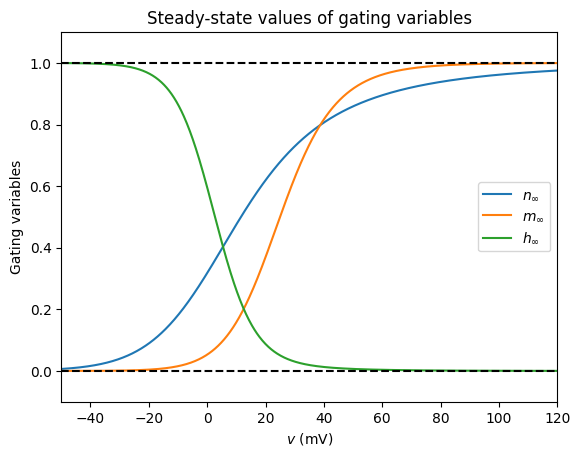

In [5]:
# 2.2) plot
plt.xlabel('$v$ (mV)')
plt.ylabel('Gating variables')
plt.xlim(-50, 120)
plt.ylim(-0.1, 1.1)
v = np.linspace(-50, 120, 1000)
plt.plot(v, n_inf(v), label='$n_{\infty}$')
plt.plot(v, m_inf(v), label='$m_{\infty}$')
plt.plot(v, h_inf(v), label='$h_{\infty}$')
plt.title('Steady-state values of gating variables')
# agrego valor maximo y minimo de cada variable
plt.plot([-50, 120], [0, 0], 'k--')
plt.plot([-50, 120], [1, 1], 'k--')
plt.legend()
plt.show()

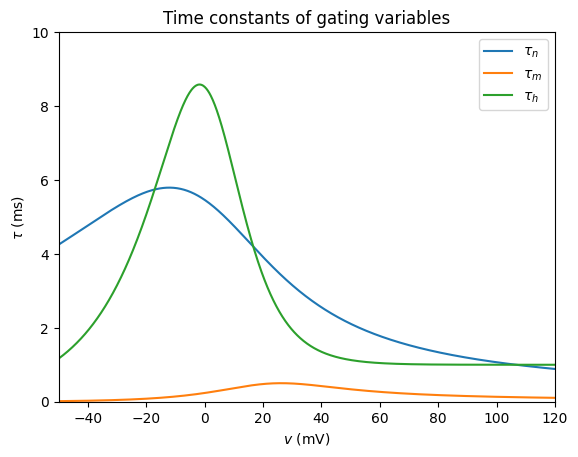

In [6]:
# 2.3)
# graficar los tiempos caracteristicos de las variables de activacion
plt.xlabel('$v$ (mV)')
plt.ylabel('$\\tau$ (ms)')
plt.xlim(-50, 120)
plt.ylim(0, 10)
v = np.linspace(-50, 120, 1000)
plt.plot(v, tau_n(v), label='$\\tau_n$')
plt.plot(v, tau_m(v), label='$\\tau_m$')
plt.plot(v, tau_h(v), label='$\\tau_h$')
plt.title('Time constants of gating variables')
plt.legend()
plt.show()

## Ejercicio 3) valores de equilibrio

**1)** Integre el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a una corriente total $i(t)=0$ para todo $t$. Use la condición inicial $v_0=0mV$, $n_0=m_0=h_0=0$ y $t_0=0ms$. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

**2)** Grafique el potencial de membrana en función del tiempo, i.e. grafique $v(t)$ vs $t$ en el rango calculado.

**3)** Grafique las diferentes corrientes de iones cruzando la membrana en función del tiempo, i.e. grafique  la corriente de iones de sodio $i_{Na}(t)$, la corriente de iones de potasio $i_K(t)$ y la corriente de pérdida $i_l(t)$ vs $t$ en el rango calculado.

**4)** Grafique las fracción de canales activados e inactivados de cada tipo en función del tiempo, i.e. grafique $n(t)$ (fracción de canales de potasio $K$ activos), $m(t)$ (fracción de canales de sodio $Na$ activos) y $h(t)$ (fracción de canales de sodio $Na$ inactivos) vs $t$ en el rango calculado.

**4)** Almacene los valores de equilibrio a corriente nula de las variables dinámicas usando los valores de las mismas obtenidos a tiempos largos. Es decir, almacene los valores $v^* \approx v(t_f)$, $n^* \approx n(t_f)$, $m^* \approx m(t_f)$ y $h^* \approx h(t_f)$, para ser utilizado como condiciones iniciales en futuras integraciones de las ODEs del modelo de Hodgkin y Huxley.

In [7]:
# 3.1)

# Parámetros
c = 1
gna = 120
gk = 36
gl = 0.3
vna = 120
vk = -12
vl = 10.6
i_t = 0

params = [c, gna, gk, gl, vna, vk, vl, lambda t: i_t]

# Condiciones iniciales
v0 = 0
n0 = 0
m0 = 0
h0 = 0

condiciones_iniciales = np.array([v0, n0, m0, h0])

t_inicial = 0
t_final = 500
h = 0.01

tiempo_pasos = int((t_final - t_inicial) / h)

t, w = integrador_ode(rk4, f, condiciones_iniciales,
                      t_inicial, t_final, tiempo_pasos, params)

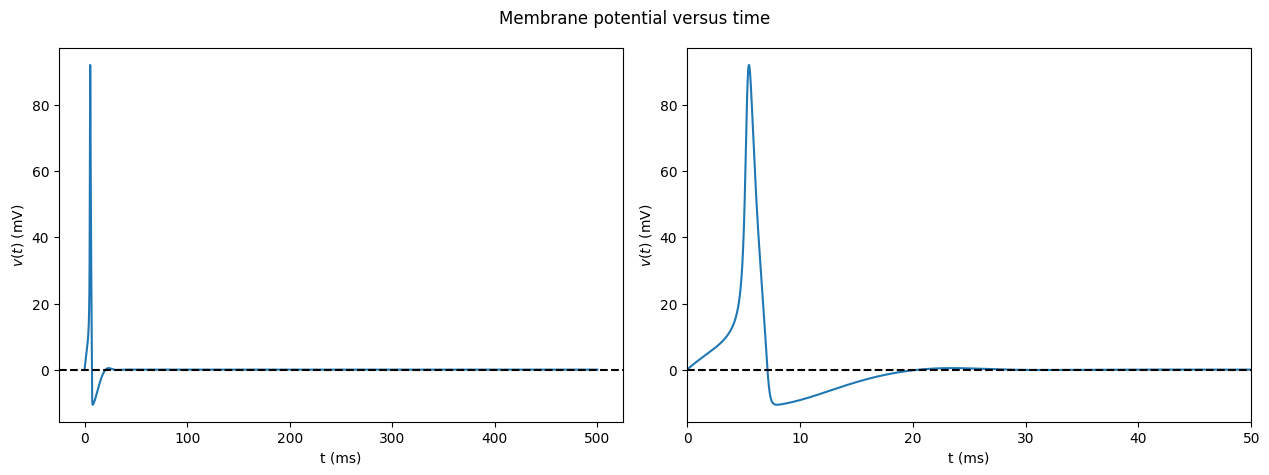

In [8]:
# 3.2)

fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

for i in range(2):
    axs[i].plot(t, w[0, :], label="$x(t)$")
    axs[i].axhline(y=0, color='k', linestyle='--')
    axs[i].set_xlabel('t (ms)')
    axs[i].set_ylabel('$v (t)$ (mV)')

axs[1].set_xlim(0, 50)

plt.suptitle('Membrane potential versus time')
plt.tight_layout()
plt.show()

In [9]:
# 3.3)

ina_valores = list(map(lambda x: ina(x, params), w.T))
ik_valores = list(map(lambda x: ik(x, params), w.T))
il_valores = list(map(lambda x: il(x, params), w.T))

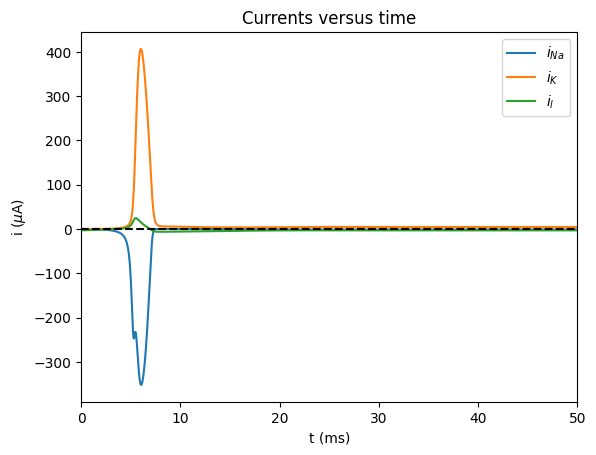

In [10]:
corrientes = [ina_valores, ik_valores, il_valores]
etiquetas = ['$i_{Na}$', '$i_{K}$', '$i_{l}$']

for idx, corriente in enumerate(corrientes):
    plt.plot(t, corriente, label=etiquetas[idx])

plt.axhline(y=0, color='k', linestyle='--')

plt.xlim(0, 50)

plt.xlabel('t (ms)')
plt.ylabel('i ($\mu$A)')
plt.legend()
plt.title('Currents versus time')

plt.show()

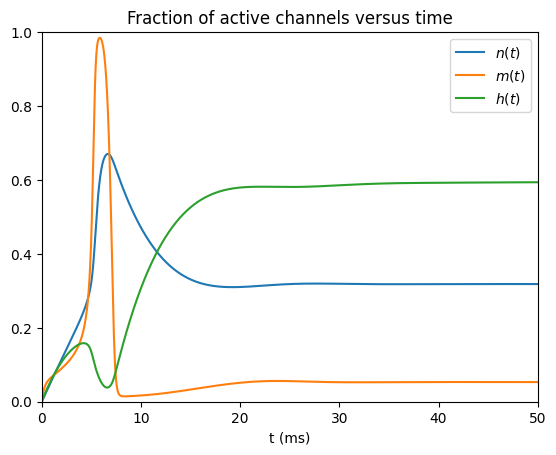

In [11]:
# 3.4)

etiquetas = ['$n(t)$', '$m(t)$', '$h(t)$']

for i in range(1, 4):
    plt.plot(t, w[i, :], label=etiquetas[i-1])

plt.xlim(0, 50)
plt.ylim(0, 1)

plt.xlabel('t (ms)')
plt.legend()
plt.title('Fraction of active channels versus time')

plt.show()

In [12]:
# guardamos el valor de equilibrio para luego iterar
x0 = w[:, -1]
print(x0)

[0.04621486 0.31838536 0.05322163 0.59450359]


## Ejercicio 4) estímulo débil y estímulo fuerte

**1)** Implemente una función de corriente de entrada o membrana dada por:

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [2ms,2.5ms] \\
30 \mu A/cm^2, & t\in [10ms,10.5ms] \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Aquí, $c.c.$ indica *en caso contrario*. Esta corriente representa un estímulo débil seguido de uno fuerte. Grafíque la corriente $i(t)$ vs $t$ en el rango $t\in[0ms,20ms]$.

**2)** Integre nuevamente el sistema de ODEs del modelo de Hodgkin y Huxley sujeto a la corriente del inciso anterior. Use como condición inicial a tiempo $t=0$ los valores de equilibrio estimados en el ejercicio anterior. Integre hasta el tiempo final $t_f=500ms$ usando un paso temporal $dt=0.01ms$.

**3)** Grafique el potencial de membrana en función del tiempo, i.e. $v(t)$ vs $t$ en el rango calculado.

**4)** Grafique la evolución de las fraciones de canales activos e inactivos, $n(t)$, $m(t)$ y $h(t)$ vs $t$.

**5)** Discuta como responde la neurona en el primer impulso a $t=2ms$. Luego, como responde al segundo impulso a $t=10ms$. Existe una diferencia? Explique.


In [13]:
# 4.1)


def estimulo(t):
    if t >= 2 and t <= 2.5:
        return 10

    elif t >= 10 and t <= 10.5:
        return 30

    else:
        return 0

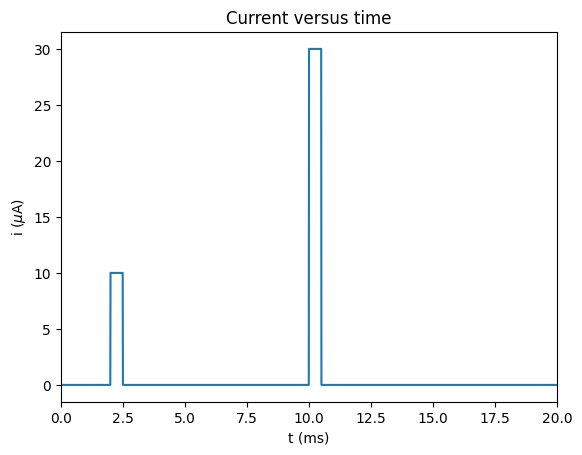

In [14]:
t_inicial = 0
t_final = 20
h = 0.01

tiempo_pasos = int((t_final - t_inicial) / h)
tiempo = np.linspace(t_inicial, t_final, tiempo_pasos)

corriente = list(map(estimulo, tiempo))

plt.plot(tiempo, corriente)

plt.xlim(0, 20)

plt.xlabel('t (ms)')
plt.ylabel('i ($\mu$A)')
plt.title('Current versus time')
plt.show()

In [15]:
# 4.2)

params = [c, gna, gk, gl, vna, vk, vl, estimulo]

# Condiciones iniciales
v0 = x0[0]
n0 = x0[1]
m0 = x0[2]
h0 = x0[3]

condiciones_iniciales = np.array([v0, n0, m0, h0])

t_inicial = 0
t_final = 500
h = 0.01

tiempo_pasos = int((t_final - t_inicial) / h)

t_estimulo, w_estimulo = integrador_ode(
    rk4, f, condiciones_iniciales, t_inicial, t_final, tiempo_pasos, params)

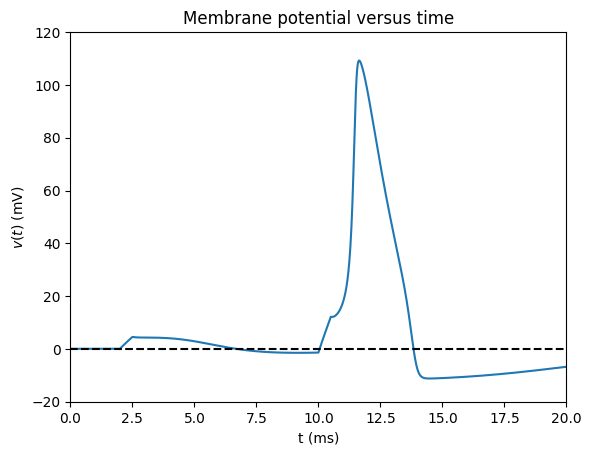

In [16]:
plt.plot(t_estimulo, w_estimulo[0, :], label="$x(t)$")
plt.axhline(y=0, color='k', linestyle='--')

plt.xlim(0, 20)
plt.ylim(-20, 120)

plt.xlabel('t (ms)')
plt.ylabel('$v (t)$ (mV)')
plt.title('Membrane potential versus time')
plt.show()

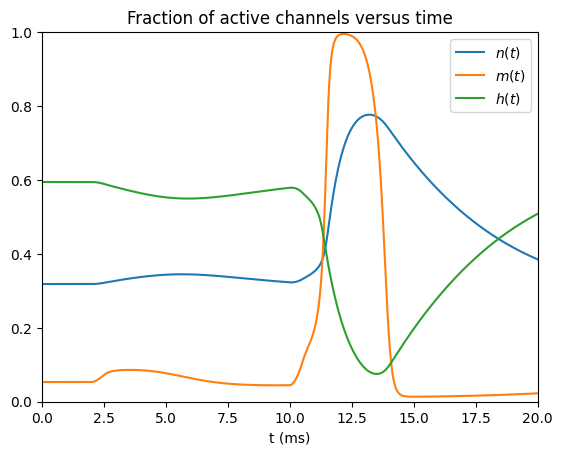

In [17]:
# 4.4)

etiquetas = ['$n(t)$', '$m(t)$', '$h(t)$']

for i in range(1, 4):
    plt.plot(t_estimulo, w_estimulo[i, :], label=etiquetas[i-1])

plt.xlim(0, 20)
plt.ylim(0, 1)

plt.xlabel('t (ms)')
plt.legend()
plt.title('Fraction of active channels versus time')

plt.show()

## Ejercicio 5) ráfaga

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [5ms,\infty ms) \\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

Esta corriente representa un estímulo constante.

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando como condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [18]:
# 5.1)

def i(t):
    if t >= 5:
        return 10.0
    else:
        return 0.0

Text(0.5, 1.0, 'Corriente de membrana')

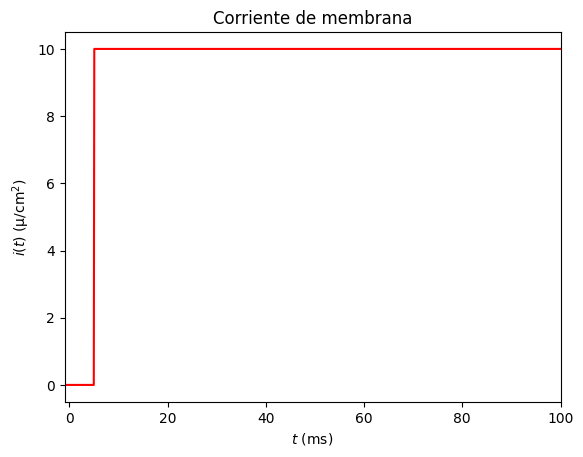

In [19]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$i(t)$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-1, 100)
t = np.linspace(-1, 100, 1000)
plt.plot(t, np.vectorize(i)(t), c='r')
plt.title('Corriente de membrana')

In [20]:
# 5.2)
# Integramos desde el equilibrio
tini = 0  # ms
tend = 100  # ms
h = 0.01  # ms
k = int((tend-tini)/h)
p = [c, gna, gk, gl, vna, vk, vl, i]
t, w = integrador_ode(rk4, f, x0, tini, tend, k, p)

Text(0.5, 1.0, 'Potencial de membrana')

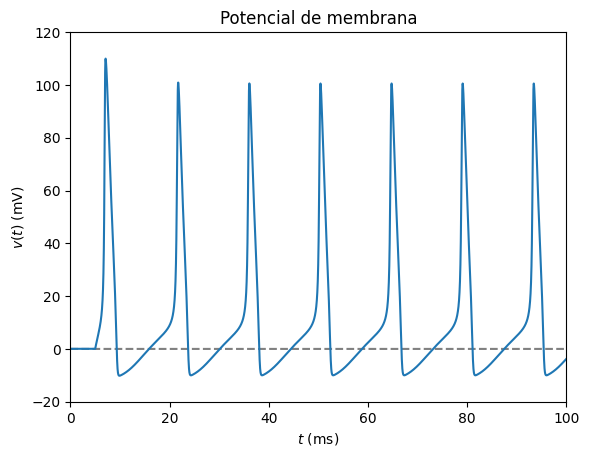

In [21]:
# 5.3)
# Graficamos potencial de membrana
plt.xlabel('$t$ (ms)')
plt.ylabel('$v(t)$ (mV)')
plt.xlim(0, 100)
plt.ylim(-20, 120)
plt.plot(t, 0*t, linestyle='--', c='gray')
plt.plot(t, w[0, :])
plt.title('Potencial de membrana')

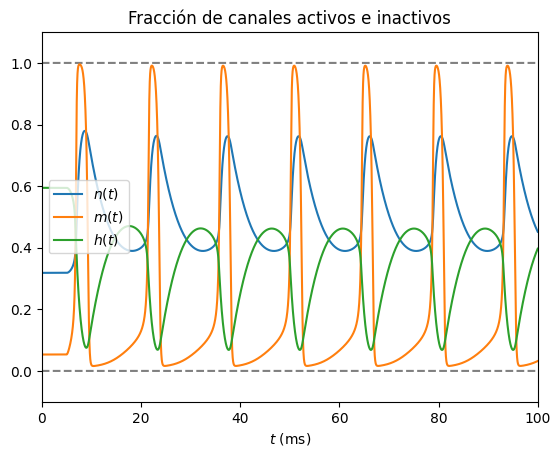

In [22]:
# Graficamos fracciones de activación e inactivación de canales
plt.xlabel('$t$ (ms)')
plt.xlim(0, 100)
plt.ylim(-0.1, 1.1)
plt.plot(t, 0*t, label="", linestyle='--', c='gray')
plt.plot(t, 0*t+1, label="", linestyle='--', c='gray')
plt.plot(t, w[1, :], label='$n(t)$')
plt.plot(t, w[2, :], label='$m(t)$')
plt.plot(t, w[3, :], label='$h(t)$')
plt.title('Fracción de canales activos e inactivos')
plt.legend()

## Ejercicio 6) período refractario

**1)** Implemente la corriente de membrana

$$
i(t) = \left\{
\begin{array}{ll}
10 \mu A/cm^2, & t\in [10ms\, k,10 ms\, k + 2ms], k \in \{1,2,3,4,5,...\}\\
0 \mu A/cm^2, & c.c. \\
\end{array}
\right.
$$

**2)** Integre nuevamente las ODEs para $t\in[0ms,100ms]$, usando la corriente del inciso **12)**, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Discuta lo que observa y explique.

In [23]:
# 6.1)

def i(t):
    for n in range(1, 10):
        if t >= 10*n and t <= 10*n+2:
            return 10.0
    return 0.0

Text(0.5, 1.0, 'Corriente de membrana')

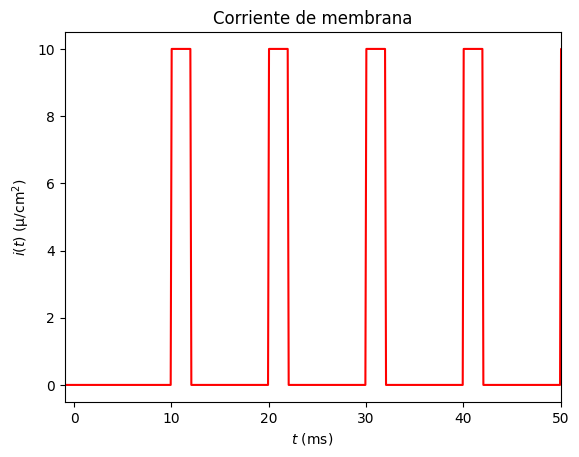

In [24]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$i(t)$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-1, 50)
t = np.linspace(-1, 100, 1000)
plt.plot(t, np.vectorize(i)(t), c='r')
plt.title('Corriente de membrana')

In [25]:
# 6.2)
tini = 0  # ms
tend = 50  # ms
h = 0.01  # ms
k = int((tend-tini)/h)
p = [c, gna, gk, gl, vna, vk, vl, i]
t, w = integrador_ode(rk4, f, x0, tini, tend, k, p)

Text(0.5, 1.0, 'Potencial de membrana')

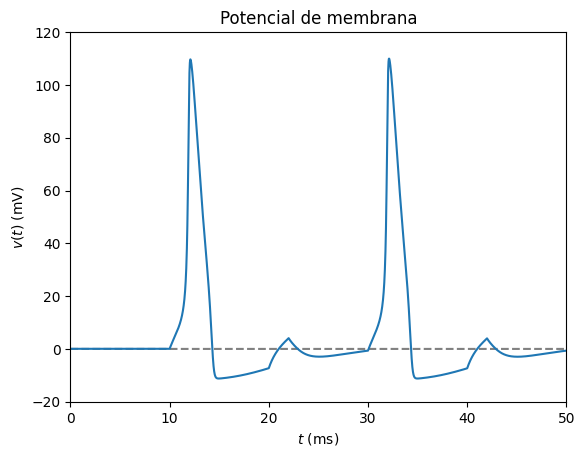

In [26]:
# 6.3)
plt.xlabel('$t$ (ms)')
plt.ylabel('$v(t)$ (mV)')
plt.xlim(0, 50)
plt.ylim(-20, 120)
plt.plot(t, 0*t, linestyle='--', c='gray')
plt.plot(t, w[0, :])
plt.title('Potencial de membrana')

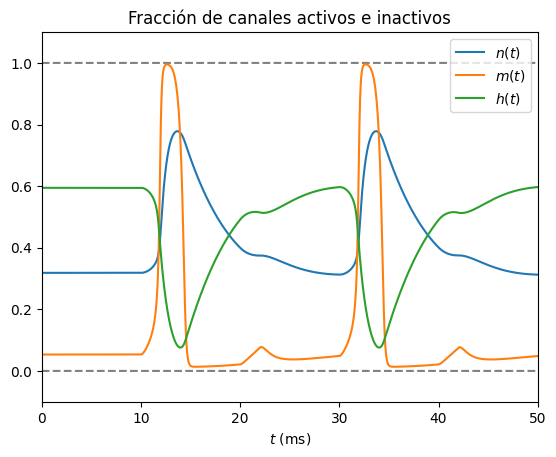

In [27]:
# 6.4)
plt.xlabel('$t$ (ms)')
plt.xlim(0, 50)
plt.ylim(-0.1, 1.1)
plt.plot(t, 0*t, label="", linestyle='--', c='gray')
plt.plot(t, 0*t+1, label="", linestyle='--', c='gray')
plt.plot(t, w[1, :], label='$n(t)$')
plt.plot(t, w[2, :], label='$m(t)$')
plt.plot(t, w[3, :], label='$h(t)$')
plt.title('Fracción de canales activos e inactivos')
plt.legend()

## Ejercicio 7) exitaciones espontáneas en respuesta al ruido

**1)** Implemente una corriente estocástica que retorne un valor $i(t)\sim i_0 N(0,1)$ (i.e. $i_0$ por un valor aleatorio obtenido de una distribución normal de media 0 y varianza 1) para cada valor de $t$ en el que sea evaluada.

**2)** Integre nuevamente las ODEs para $t\in[0ms,500ms]$, usando la corriente del inciso **22)** para $i_0=50\mu A$, la condición incial los valores de equilibrio derivados en el inciso **6)** y un paso de integración $dt=0.01$.

**3)** Grafique nuevamente el potencial de membrana en el rango de tiempos calculado.

**4)** Grafique nuevamente fracciones de canales activos e inactivos vs el tiempo.

**5)** Observa picos de activación cada tanto? Aparecen con regularidad? Estime con que frecuencia observa los picos.

In [28]:
# 7.1)
# 7.1)
# i0 : nivel de ruido determinado por la desviación estandard de una 
# distribucion normal centrada en 0.
i0 = 50


def i(t):
    return i0*np.random.normal()

Text(0.5, 1.0, 'Corriente de membrana')

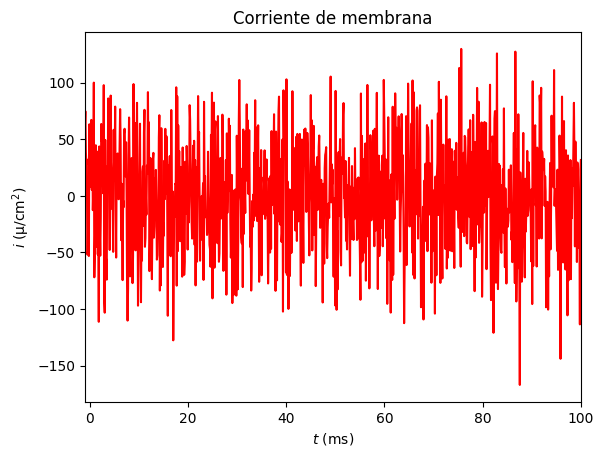

In [29]:
plt.xlabel('$t$ (ms)')
plt.ylabel('$i$ $\mathrm{(\mu/cm^2)}$')
plt.xlim(-1, 100)
t = np.linspace(-1, 100, 1000)
plt.plot(t, np.vectorize(i)(t), c='r')
plt.title('Corriente de membrana')

In [30]:
# 7.2)
tini = 0  # ms
tend = 500  # ms
h = 0.01  # ms
k = int((tend-tini)/h)
p = [c, gna, gk, gl, vna, vk, vl, i]
t, w = integrador_ode(rk4, f, x0, tini, tend, k, p)

Text(0.5, 1.0, 'Potencial de membrana')

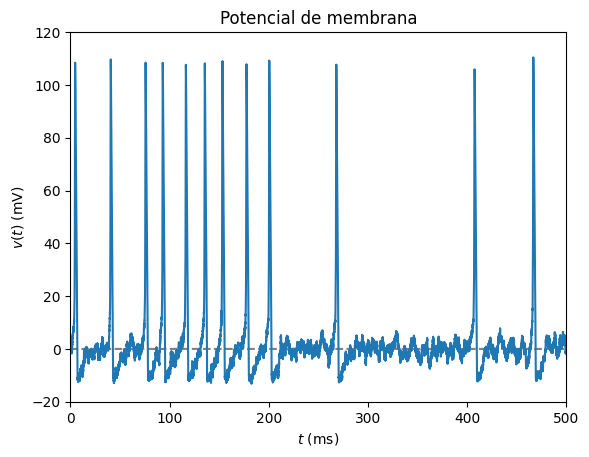

In [31]:
# 7.3)
plt.xlabel('$t$ (ms)')
plt.ylabel('$v(t)$ (mV)')
plt.xlim(tini, tend)
plt.ylim(-20, 120)
plt.plot(t, 0*t, linestyle='--', c='gray')
plt.plot(t, w[0, :])
plt.title('Potencial de membrana')

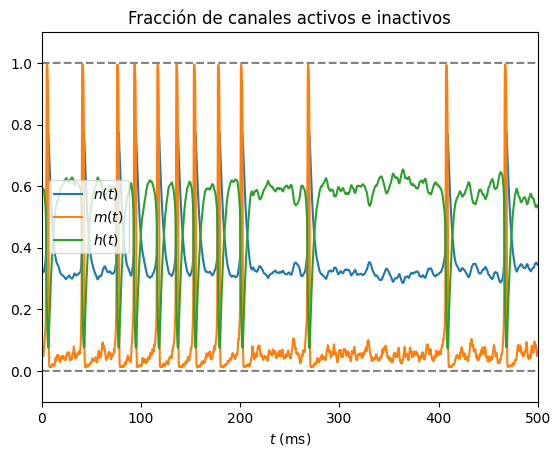

In [32]:
plt.xlabel('$t$ (ms)')
plt.xlim(tini, tend)
plt.ylim(-0.1, 1.1)
plt.plot(t, 0*t, label="", linestyle='--', c='gray')
plt.plot(t, 0*t+1, label="", linestyle='--', c='gray')
plt.plot(t, w[1, :], label='$n(t)$')
plt.plot(t, w[2, :], label='$m(t)$')
plt.plot(t, w[3, :], label='$h(t)$')
plt.title('Fracción de canales activos e inactivos')
plt.legend()